# Amazon Customer Data Wrangling

Data from
> Justifying recommendations using distantly-labeled reviews and fined-grained aspects
Jianmo Ni, Jiacheng Li, Julian McAuley
Empirical Methods in Natural Language Processing (EMNLP), 2019

In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# koalas
import databricks.koalas as ks

# spark tools
from pyspark import SparkConf, SparkContext
from pyspark.ml.stat import Summarizer
from pyspark.sql import Row, SQLContext
from pyspark.sql.functions import isnan, when, count, col, countDistinct

In [2]:
# initiate spark context
sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

In [3]:
# read in the data to a koalas dataframe
bks_df = ks.read_json('../Amazon_Data/Books.json.gz', compression='gzip')

In [4]:
# inspect the column
bks_df.columns

Index(['asin', 'image', 'overall', 'reviewText', 'reviewTime', 'reviewerID',
       'reviewerName', 'style', 'summary', 'unixReviewTime', 'verified',
       'vote'],
      dtype='object')

In [5]:
# inspect the shape
bks_df.shape

(51311621, 12)

In [7]:
bks_df.groupby('overall')['asin'].count()

overall
0.0           8
1.0     2088314
4.0     9557650
3.0     3835225
2.0     1850688
5.0    33979736
Name: asin, dtype: int64

In [8]:
# convert the star ratings to a numpy array
# getting memory/space errors
# same issues with running .head()
overall_np = bks_df.overall.to_numpy()

Py4JJavaError: An error occurred while calling o297.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 12.0 failed 1 times, most recent failure: Lost task 0.0 in stage 12.0 (TID 11, localhost, executor driver): java.lang.OutOfMemoryError: Java heap space
	at java.util.Arrays.copyOf(Arrays.java:3236)
	at java.io.ByteArrayOutputStream.grow(ByteArrayOutputStream.java:118)
	at java.io.ByteArrayOutputStream.ensureCapacity(ByteArrayOutputStream.java:93)
	at java.io.ByteArrayOutputStream.write(ByteArrayOutputStream.java:153)
	at net.jpountz.lz4.LZ4BlockOutputStream.flushBufferedData(LZ4BlockOutputStream.java:220)
	at net.jpountz.lz4.LZ4BlockOutputStream.write(LZ4BlockOutputStream.java:173)
	at java.io.DataOutputStream.write(DataOutputStream.java:107)
	at org.apache.spark.sql.catalyst.expressions.UnsafeRow.writeToStream(UnsafeRow.java:554)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:258)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:247)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:836)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:836)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1889)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1877)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1876)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1876)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2110)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2059)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2048)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2126)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:945)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:944)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:299)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:3263)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:3260)
	at org.apache.spark.sql.Dataset$$anonfun$52.apply(Dataset.scala:3370)
	at org.apache.spark.sql.execution.SQLExecution$$anonfun$withNewExecutionId$1.apply(SQLExecution.scala:78)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:73)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3369)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3260)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.lang.OutOfMemoryError: Java heap space
	at java.util.Arrays.copyOf(Arrays.java:3236)
	at java.io.ByteArrayOutputStream.grow(ByteArrayOutputStream.java:118)
	at java.io.ByteArrayOutputStream.ensureCapacity(ByteArrayOutputStream.java:93)
	at java.io.ByteArrayOutputStream.write(ByteArrayOutputStream.java:153)
	at net.jpountz.lz4.LZ4BlockOutputStream.flushBufferedData(LZ4BlockOutputStream.java:220)
	at net.jpountz.lz4.LZ4BlockOutputStream.write(LZ4BlockOutputStream.java:173)
	at java.io.DataOutputStream.write(DataOutputStream.java:107)
	at org.apache.spark.sql.catalyst.expressions.UnsafeRow.writeToStream(UnsafeRow.java:554)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:258)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$2.apply(SparkPlan.scala:247)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:836)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitionsInternal$1$$anonfun$apply$24.apply(RDD.scala:836)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [3]:
# read the data into a spark rdd
books_rdd = sc.textFile('../Amazon_Data/Books.json.gz')

In [5]:
# inspect the rdd
books_rdd.take(3)

['{"overall": 5.0, "verified": false, "reviewTime": "08 12, 2005", "reviewerID": "A1C6M8LCIX4M6M", "asin": "0001713353", "style": {"Format:": " Paperback"}, "reviewerName": "June Bug", "reviewText": "This book is a winner with both of my boys.  They really enjoy the pictures and the story.  It\'s a classic.", "summary": "Children\'s favorite", "unixReviewTime": 1123804800}',
 '{"overall": 5.0, "verified": false, "reviewTime": "03 30, 2005", "reviewerID": "A1REUF3A1YCPHM", "asin": "0001713353", "style": {"Format:": " Hardcover"}, "reviewerName": "TW Ervin II", "reviewText": "The King, the Mice and the Cheese by Nancy Gurney is an excellent children\'s book.  It is one that I well remember from my own childhood and purchased for my daughter who loves it.\\n\\nIt is about a king who has trouble with rude mice eating his cheese. He consults his wise men and they suggest cats to chase away the mice. The cats become a nuisance, so the wise men recommend the king bring in dogs to chase the ca

In [ ]:
# get the headers from the json
#headers = books_rdd.map()

In [ ]:


# parse the json in the rdd
#books_mapped = books_rdd.map()

In [6]:
# read in data to spark df
books_df = spark.read.json('../Amazon_Data/Books.json.gz')

In [7]:
# review the structure of the spark dataframe
books_df.printSchema()

root
 |-- asin: string (nullable = true)
 |-- image: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- style: struct (nullable = true)
 |    |-- Color:: string (nullable = true)
 |    |-- Format:: string (nullable = true)
 |    |-- Package Quantity:: string (nullable = true)
 |    |-- Size:: string (nullable = true)
 |    |-- Style Name:: string (nullable = true)
 |    |-- Style:: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)
 |-- verified: boolean (nullable = true)
 |-- vote: string (nullable = true)



#### Books Data Notes
- 'reviewerID' is the customer ID
- 'overall' is the star rating (ranges 0 to 5)
- 'asin' is the ID of the product
    - 'title' of the product is located in the metadata file, join by 'asin'

In [8]:
books_df.take(5)[0]

Row(asin='0001713353', image=None, overall=5.0, reviewText="This book is a winner with both of my boys.  They really enjoy the pictures and the story.  It's a classic.", reviewTime='08 12, 2005', reviewerID='A1C6M8LCIX4M6M', reviewerName='June Bug', style=Row(Color:=None, Format:=' Paperback', Package Quantity:=None, Size:=None, Style Name:=None, Style:=None), summary="Children's favorite", unixReviewTime=1123804800, verified=False, vote=None)

In [9]:
# books_df.dtypes

In [22]:
# register df as table
#sqlContext.registerDataFrameAsTable(books_df, 'books_df')

In [10]:
# get count of missing values
reviews_ratings = books_df.select('reviewText', 'overall')
reviews_ratings.select([count(when(isnan(c), c)).alias(c) for c in reviews_ratings.columns]).show()

+----------+-------+
|reviewText|overall|
+----------+-------+
|         0|      0|
+----------+-------+



In [11]:
# split into labels and features
reviews = reviews_ratings.select('reviewText')
ratings = reviews_ratings.select('overall')

In [12]:
# inspect the reviews
reviews.take(2)

[Row(reviewText="This book is a winner with both of my boys.  They really enjoy the pictures and the story.  It's a classic."),
 Row(reviewText="The King, the Mice and the Cheese by Nancy Gurney is an excellent children's book.  It is one that I well remember from my own childhood and purchased for my daughter who loves it.\n\nIt is about a king who has trouble with rude mice eating his cheese. He consults his wise men and they suggest cats to chase away the mice. The cats become a nuisance, so the wise men recommend the king bring in dogs to chase the cats away.  The cycle goes on until the mice are finally brought back to chase away the elephants, brought in to chase away the lions that'd chased away the dogs.\n\nThe story ends in compromise and friendship between the mice and the king.  The story also teaches cause and effect relationships.\n\nThe pictures that accompany the story are humorous and memorable.  I was thrilled to discover that it is back in print.  I *highly* recommend

In [13]:
# inspect the ratings
ratings.take(2)

[Row(overall=5.0), Row(overall=5.0)]

In [14]:
# display the number of ratings
ratings.count()

51311621

In [15]:
# display the number of reviews
reviews.count()

51311621

In [16]:
# store counts of ratings by number of stars and show
ratings_df = reviews_ratings.groupby('overall').count().sort(col('overall'))
ratings_df.show()

+-------+--------+
|overall|   count|
+-------+--------+
|    0.0|       8|
|    1.0| 2088314|
|    2.0| 1850688|
|    3.0| 3835225|
|    4.0| 9557650|
|    5.0|33979736|
+-------+--------+



In [17]:
# convert to pandas df for easy plotting
ratings_hist = ratings_df.toPandas()

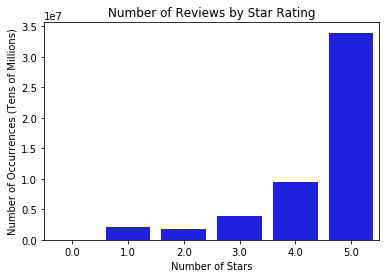

In [18]:
# visualize the number of ratings for each level
_ = sns.barplot(ratings_hist['overall'], ratings_hist['count'], color='blue')
_ = plt.title('Number of Reviews by Star Rating')
_ = plt.xlabel('Number of Stars')
_ = plt.ylabel('Number of Occurrences (Tens of Millions)')

In [21]:
# map the ratings to positive, neutral, and negative
ratings_hist.loc[:,'sentiment'] = ratings_hist.overall.map({0.0: 'negative', 1.0: 'negative', 2.0: 'negative',
                                                           3.0: 'neutral', 4.0: 'positive', 5.0: 'positive'})

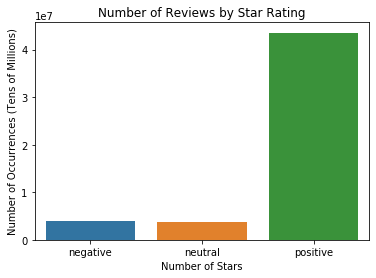

In [32]:
# visualize the number of positive, neutral, and negative ratings
_ = sns.barplot(ratings_hist['sentiment'].unique(), ratings_hist.groupby('sentiment')['count'].sum())
_ = plt.title('Number of Reviews by Star Rating')
_ = plt.xlabel('Number of Stars')
_ = plt.ylabel('Number of Occurrences (Tens of Millions)')

In [69]:
# map the spark dataframe target for multiclass evaluation
ratings_map_neg = ratings.withColumn('negative', ratings.overall < 3.0).select('overall', 'negative')
ratings_map_neut = ratings_map_neg.withColumn('neutral', ratings_map_neg.overall == 3.0).select('overall', 'negative', 'neutral')
ratings_mapped = ratings_map_neut.withColumn('positive', ratings_map_neut.overall > 3.0).select('overall', 'negative', 'neutral', 'positive')

In [109]:
# inspect the results
ratings_mapped.show(100)

+-------+--------+-------+--------+
|overall|negative|neutral|positive|
+-------+--------+-------+--------+
|    5.0|   false|  false|    true|
|    5.0|   false|  false|    true|
|    5.0|   false|  false|    true|
|    5.0|   false|  false|    true|
|    5.0|   false|  false|    true|
|    5.0|   false|  false|    true|
|    5.0|   false|  false|    true|
|    5.0|   false|  false|    true|
|    5.0|   false|  false|    true|
|    5.0|   false|  false|    true|
|    5.0|   false|  false|    true|
|    5.0|   false|  false|    true|
|    5.0|   false|  false|    true|
|    4.0|   false|  false|    true|
|    5.0|   false|  false|    true|
|    5.0|   false|  false|    true|
|    5.0|   false|  false|    true|
|    5.0|   false|  false|    true|
|    5.0|   false|  false|    true|
|    5.0|   false|  false|    true|
|    5.0|   false|  false|    true|
|    5.0|   false|  false|    true|
|    5.0|   false|  false|    true|
|    5.0|   false|  false|    true|
|    5.0|   false|  false|  

In [106]:
# convert true/false values to numerical values
sa_target = ratings_mapped.select([col(c).cast('integer') for c in ['negative', 'neutral', 'positive']])

In [108]:
# inspect the results
sa_target.show(100)

+--------+-------+--------+
|negative|neutral|positive|
+--------+-------+--------+
|       0|      0|       1|
|       0|      0|       1|
|       0|      0|       1|
|       0|      0|       1|
|       0|      0|       1|
|       0|      0|       1|
|       0|      0|       1|
|       0|      0|       1|
|       0|      0|       1|
|       0|      0|       1|
|       0|      0|       1|
|       0|      0|       1|
|       0|      0|       1|
|       0|      0|       1|
|       0|      0|       1|
|       0|      0|       1|
|       0|      0|       1|
|       0|      0|       1|
|       0|      0|       1|
|       0|      0|       1|
|       0|      0|       1|
|       0|      0|       1|
|       0|      0|       1|
|       0|      0|       1|
|       0|      0|       1|
|       0|      0|       1|
|       0|      0|       1|
|       0|      0|       1|
|       0|      0|       1|
|       0|      0|       1|
|       0|      0|       1|
|       0|      0|       1|
|       0|      0|  

## Recommendation Matrix

In [ ]:
# CODE BELOW ATTEMPTED TO GENERATE A CUSTOMER LIST

In [117]:
#cust = books_df.select('reviewerID').distinct()

In [124]:
#cust.show(30)

In [127]:
# isolate the items purchased by each customer
books_df.createOrReplaceTempView('books')
items_by_cust = spark.sql('SELECT reviewerID, asin FROM books ORDER BY reviewerID').toDF('reviewerID', 'itemID')

In [130]:
# need to transform this into sparse matrix style
items_by_cust.show(5)

+--------------------+----------+
|          reviewerID|    itemID|
+--------------------+----------+
|A000033826RVJH496D4A|1502915707|
|A000033826RVJH496D4A|0895555379|
|A000033826RVJH496D4A|1612785565|
|A00007762BKXYRMOCC0A|0977645908|
|A0001176G5I54P8WV7J5|0804835500|
+--------------------+----------+
only showing top 5 rows



In [ ]:
# only need the info below to get the titles of the books
# the items and customers are in the reviews df

In [110]:
# read in data to spark df
meta_df = spark.read.json('../Amazon_Data/meta_Books.json.gz')

In [111]:
# review the structure of the spark dataframe
meta_df.printSchema()

root
 |-- also_buy: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- also_view: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- asin: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- category: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- date: string (nullable = true)
 |-- description: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- details: string (nullable = true)
 |-- feature: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- fit: string (nullable = true)
 |-- image: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- main_cat: string (nullable = true)
 |-- price: string (nullable = true)
 |-- rank: string (nullable = true)
 |-- similar_item: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- asin: string (nullable = true)
 |    |    |-- features: struct (nullabl

In [114]:
meta_df.show(2)

+--------------------+--------------------+----------+------------+--------------------+----+--------------------+-------+-------+----+-----+--------+------+-----------------+------------+-----+--------------------+
|            also_buy|           also_view|      asin|       brand|            category|date|         description|details|feature| fit|image|main_cat| price|             rank|similar_item|tech1|               title|
+--------------------+--------------------+----------+------------+--------------------+----+--------------------+-------+-------+----+-----+--------+------+-----------------+------------+-----+--------------------+
|[0669009075, B000...|[0019777701, B000...|0000092878|Keith Graham|                null|null|[It is a biology ...|   null|   null|null| null|   Books|$39.94|1,349,781inBooks(|        null| null|Biology Gods Livi...|
|                null|[B01MUCYEV7, B01K...|000047715X|         Acp|[Books, New, Used...|null|                null|   null|   null|null| 

#### Metadata Notes
- 'asin' is the item number
- 'also_buy' lists item numbers for other purchases ('people also bought')
- 'title' is the title of the book (not found in books_df)